## Advanced Lane Finding Project

### 02 Pipeline Images

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard image.**
* **Apply a distortion correction to raw images.**
* **Use color transforms, gradients, etc., to create a thresholded binary image.**
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [100]:
import cv2
import glob
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Load and show test images

In [175]:
# Load test images.
test_images = list(map(lambda filename: (filename, cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)), 
                      glob.glob('test_images/*.jpg')))

In [176]:
# Display images on a [cols, rows] subplot grid
def show_images(images, cols = 4, rows = 5, figsize=(20,15), cmap = None):
    f, axes = plt.subplots(rows, cols, figsize=figsize)
    f.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=1.4, bottom=0.)
    
    indexes = range(cols * rows)
    
    for ax, index in zip(axes.flat, indexes):
        if index < len(images):
            filename_image, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(filename_image, fontsize=30)
            
# Show test images
show_images(test_images, 2, 4, (20,15))

## Apply a distortion correction to raw images

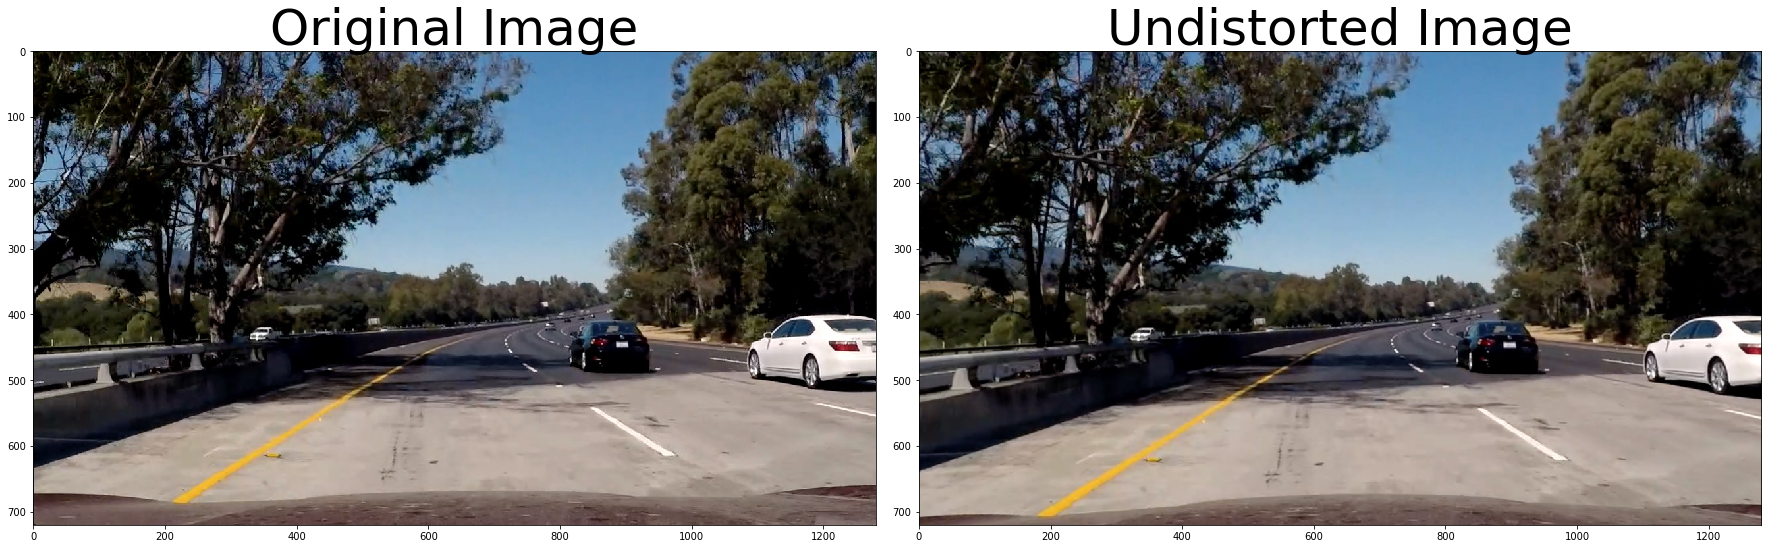

In [177]:
# Loading camera calibration (calculated in 01_Camera_Calibartion.ipynb)
camera_cal = pickle.load(open('camera_cal/camera_calibration.p', 'rb'))
mtx, dist = map(camera_cal.get, ('mtx', 'dist'))

index = 1
test_image = test_images[index][1]

undistort_image = cv2.undistort(test_image, mtx, dist, None, mtx)

#fig, axes = plt.subplots(1, 2, figsize=(20, 10))
#axes[0].imshow(test_image)
#axes[0].set_title('Original Image', fontsize=15)
#axes[1].imshow(undistort_image)
#axes[1].set_title('Undistorted Image', fontsize=15)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistort_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## Use color transforms, gradients, etc., to create a thresholded binary image

In [178]:
# Image for testing
image = mpimg.imread('output_images/signs_vehicles_xygrad.jpg')
unittest = True;

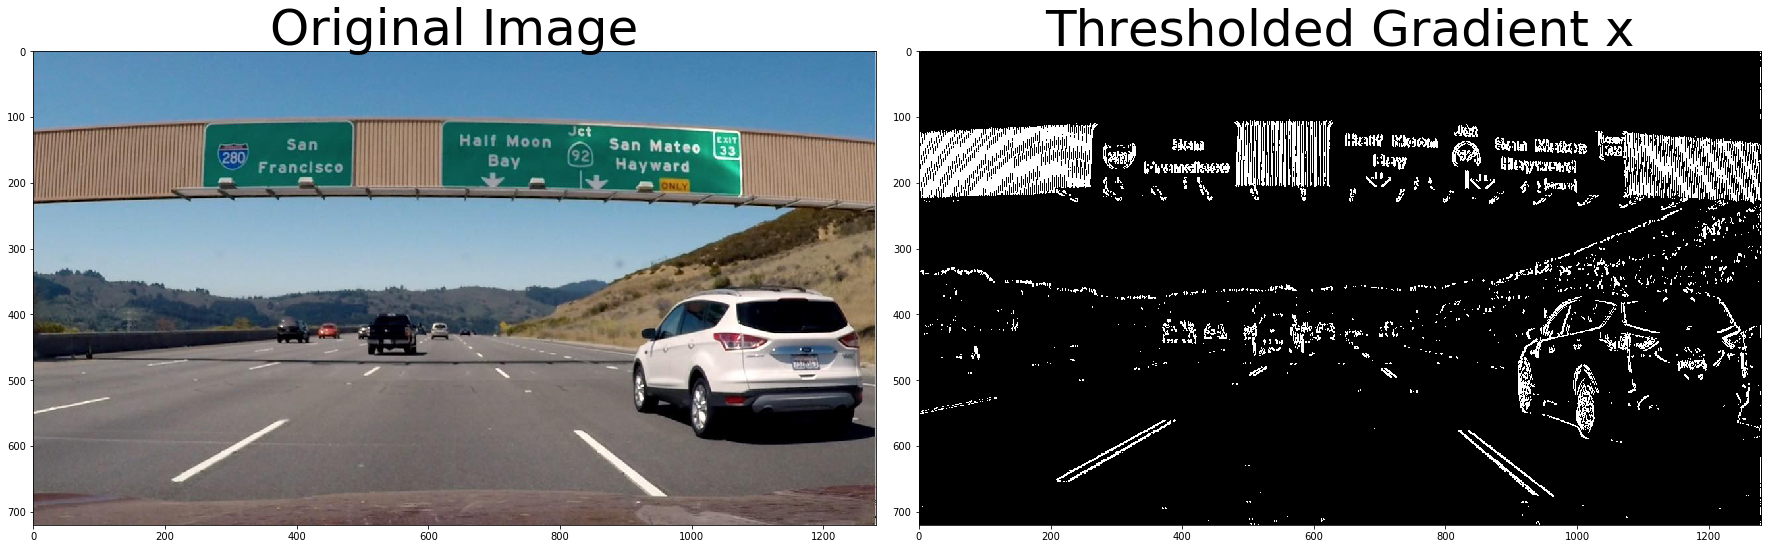

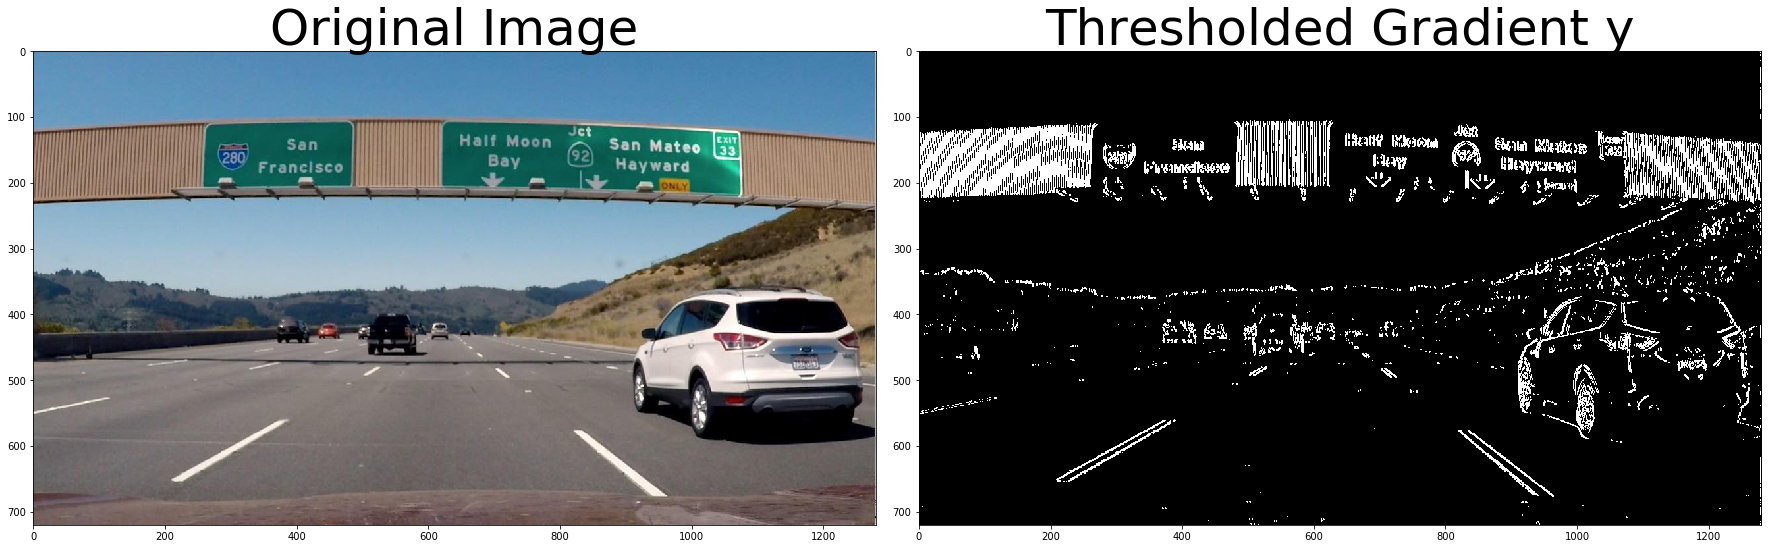

In [179]:
# Function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, abs_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    # Gradient in x direction emphasizes edges closer to vertical. 
    # Gradient in y direction emphasizes edges closer to horizontal. 
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))   
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    
    # Return the result
    return binary_output


def test_abs_sobel_thresh(orient='x'):
    # Run the function
    grad_binary = abs_sobel_thresh(image, orient='x', abs_thresh=(20, 120))
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(grad_binary, cmap='gray')
    ax2.set_title('Thresholded Gradient ' + orient, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if unittest == True:
    test_abs_sobel_thresh(orient='x');
    test_abs_sobel_thresh(orient='y');
    

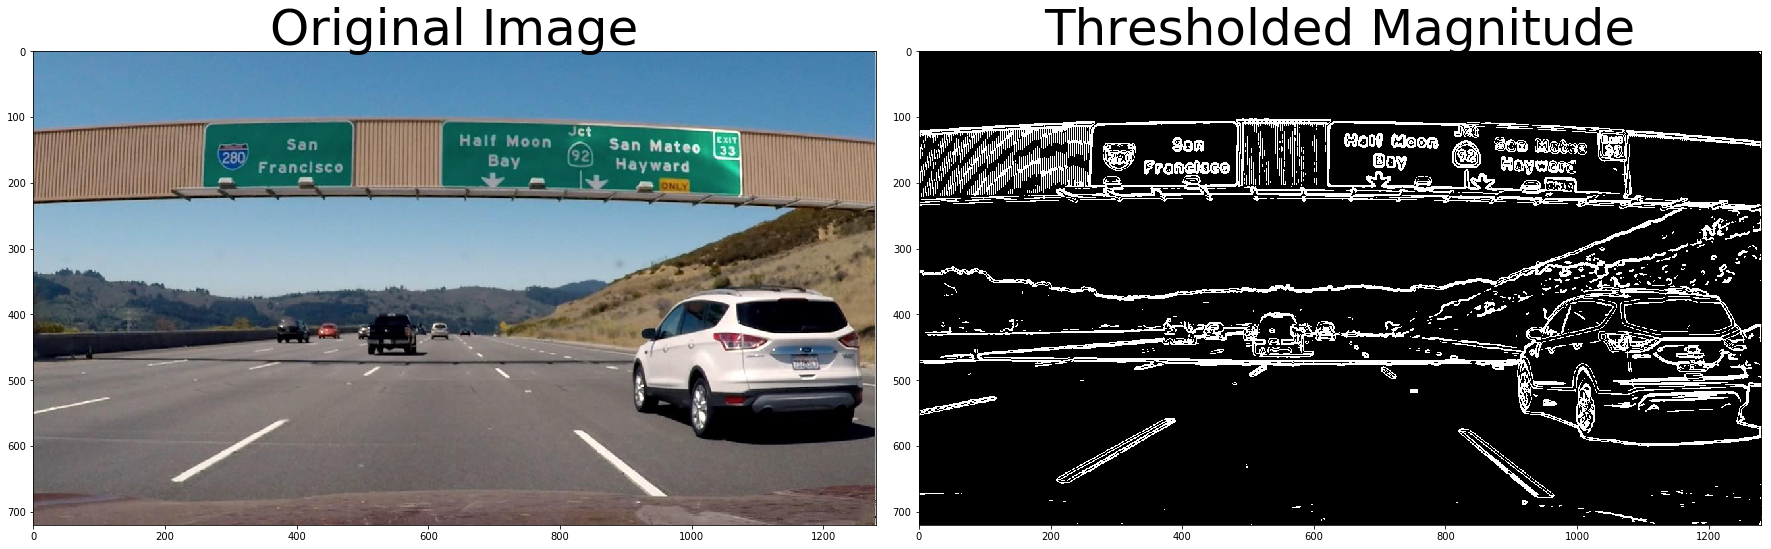

In [180]:
# Function that applies Sobel x and y, then computes the magnitude of the gradient and applies a thresholds
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Return the binary image
    return binary_output
 

def test_mag_thresh():
    # Run the function
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.set_title('Thresholded Magnitude', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if unittest == True:
    test_mag_thresh();

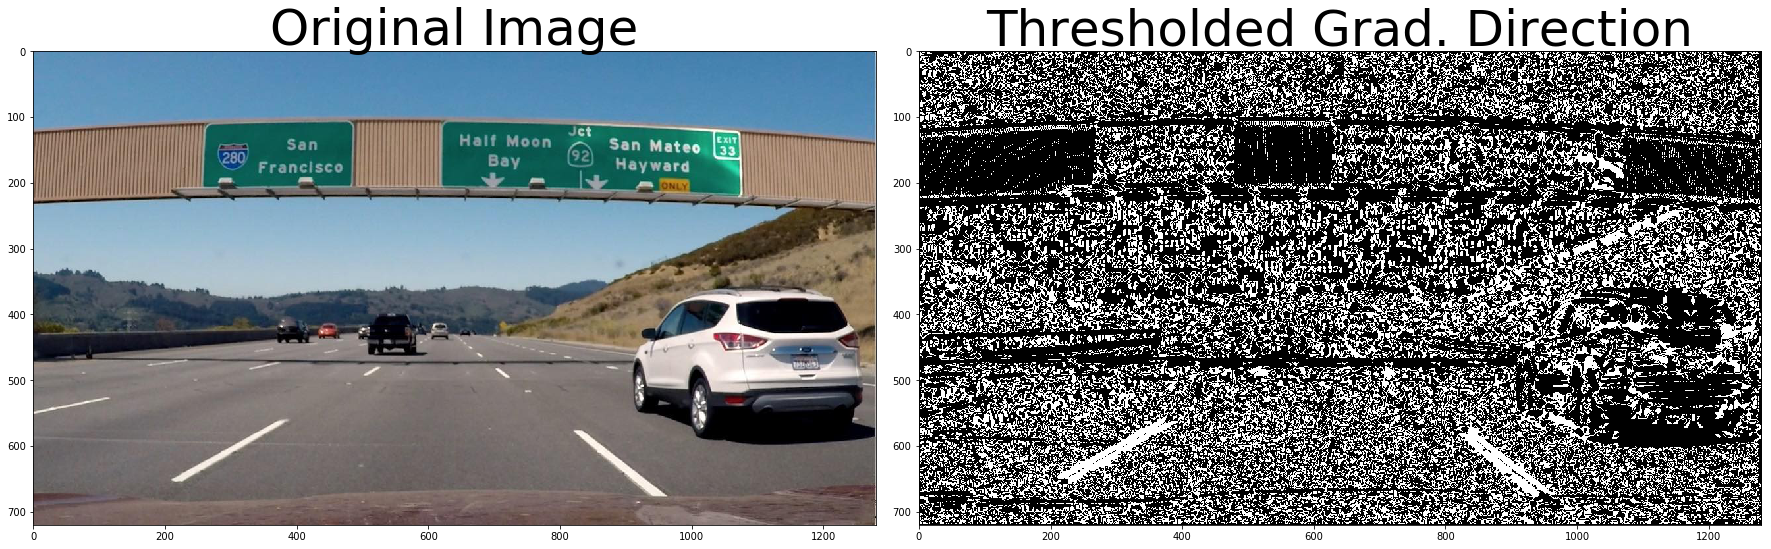

In [181]:
# Function that applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output
     

def test_dir_threshold():
    # Run the function
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dir_binary, cmap='gray')
    ax2.set_title('Thresholded Grad. Direction', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if unittest == True:
    test_dir_threshold();

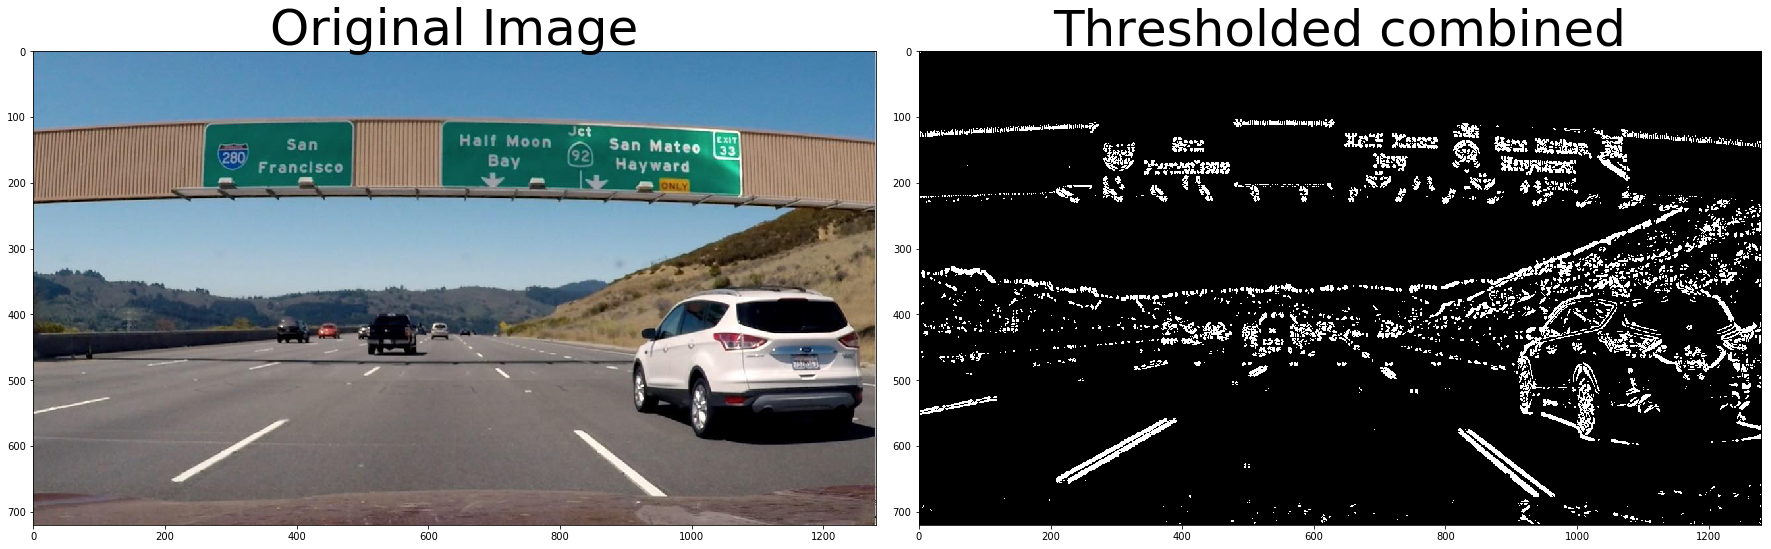

In [183]:
# Choose a Sobel kernel size
ksize = 11 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, abs_thresh=(10, 120))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, abs_thresh=(10, 120))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


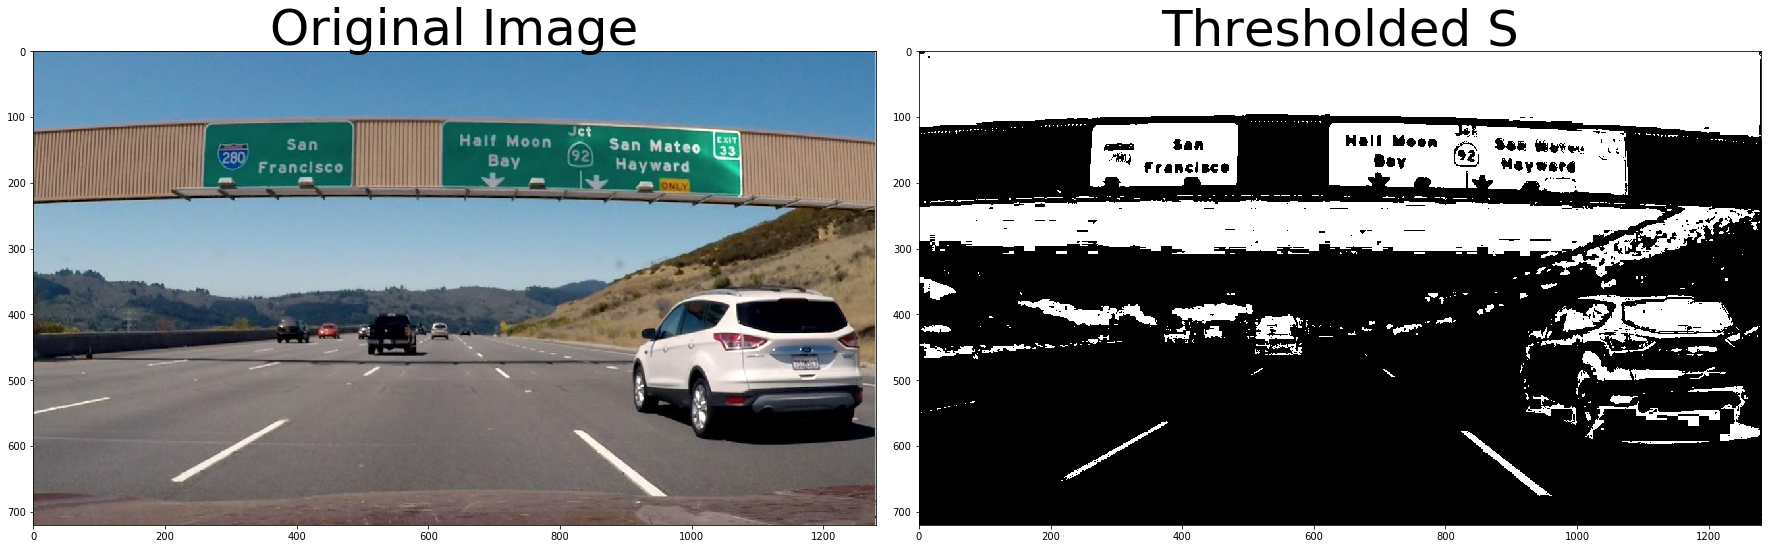

In [186]:
# Read in an image, you can also try test1.jpg or test4.jpg
# image = mpimg.imread('test6.jpg') 

# Function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
    
    
def test_hls_select():
    # Run the function
    hls_binary = hls_select(image, thresh=(90, 255))
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(hls_binary, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if unittest == True:
    test_hls_select();


In [95]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped